数据加载

In [1]:
#这两行是解决查看数据时的问题OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device=torch.device('cuda'if torch.cuda.is_available()else 'cpu')

#数据加载
#dataset
#train set
train_dataset=torchvision.datasets.MNIST(root='/data',train=True,
                                         transform=transforms.ToTensor(),
                                         download=True)
#test set
test_dataset=torchvision.datasets.MNIST(root='/data',train=False,
                                        transform=transforms.ToTensor())
print(train_dataset)
print(test_dataset)
#dataloader
batch_size=100
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=batch_size,
                                        shuffle=False)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: /data
    Split: Test
    StandardTransform
Transform: ToTensor()


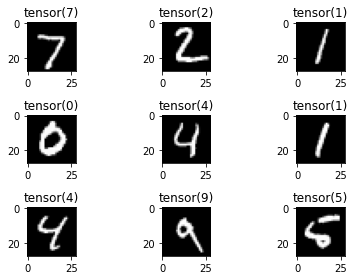

In [2]:
#查看数据
examples=iter(test_loader)
example_data,example_target=examples.next()
for i in range(9):
    plt.subplot(3,3,i+1).set_title(example_target[i])
    plt.imshow(example_data[i][0],'gray')
plt.tight_layout()
plt.show()


In [3]:
#构建网络
#输入节点数为图片大小
input_size=28*28*1
#10分类问题
num_classes=10
class NeuralNet(nn.Module):
        def __init__(self,input_size,hidden_size,num_classes):
            super(NeuralNet,self).__init__()
            self.input_size=input_size
            self.l1=nn.Linear(input_size,hidden_size)
            self.relu=nn.ReLU()
            self.l2=nn.Linear(hidden_size,num_classes)
        def forward(self,x):
            out=self.relu(self.l1(x))
            out=self.l2(out)
            return out
model=NeuralNet(input_size,500,num_classes).to(device)
model


NeuralNet(
  (l1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=500, out_features=10, bias=True)
)

In [4]:
# 简单测试模型的输出
examples = iter(test_loader)
example_data, _ = examples.next() # 100*1*28*28

#解决问题RuntimeError: Tensor for argument #2 'mat1' is on CPU, but expected it to be on GPU (while checking arguments for addmm)
example_data=example_data.to(device)

model(example_data.reshape(example_data.size(0),-1)).shape

torch.Size([100, 10])

In [5]:
#定义损失函数和优化器
learning_rate=0.001
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)


In [6]:
#模型的训练和测试
num_epochs=10
n_total_steps=len(train_loader)
LossList=[]#每一个epoch的loss
AccuryList=[]#每一个epoch的accury
for epoch in range(num_epochs):
    #训练
    model.train()#切换为训练模型
    totalLoss=0
    for i,(images,labels)in enumerate(train_loader):
        images=images.reshape(-1,28*28).to(device)
        labels=labels.to(device)
        #正向传播 
        outputs=model(images)
        loss=criterion(outputs,labels)
        #累计损失
        totalLoss+=loss.item()
        #反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()#权重更新
        #抽样调查
        if(i+1)%300==0:
            print('Epoch[{}/{}],Step[{}/{}],Loss={:.4f}'.format(epoch+1,
                  num_epochs,i+1,n_total_steps,totalLoss/(i+1)))
    #for i,(images,labels)in enumerate(train_loader):语句块结束后i不会消失，挺神奇
    LossList.append(totalLoss/(i+1))
    
    #测试
    model.eval()#切换为测试模型
    with torch.no_grad():
        correct=0
        total=0
        for images,labels in test_loader:
            images=images.reshape(-1,28*28).to(device)
            labels=labels.to(device)
            outputs=model(images)
            #预测结果
            _,predicted=torch.max(outputs.data,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
        acc=100.0*correct/total
        AccuryList.append(acc)
        print('Accuracy of the network on the {} test images: {}%'.format(
                total,acc))
print("模型训练完成")
            

Epoch[1/10],Step[300/600],Loss=0.4093
Epoch[1/10],Step[600/600],Loss=0.2972
Accuracy of the network on the 10000 test images: 95.13%
Epoch[2/10],Step[300/600],Loss=0.1281
Epoch[2/10],Step[600/600],Loss=0.1193
Accuracy of the network on the 10000 test images: 97.09%
Epoch[3/10],Step[300/600],Loss=0.0781
Epoch[3/10],Step[600/600],Loss=0.0770
Accuracy of the network on the 10000 test images: 97.43%
Epoch[4/10],Step[300/600],Loss=0.0524
Epoch[4/10],Step[600/600],Loss=0.0548
Accuracy of the network on the 10000 test images: 97.92%
Epoch[5/10],Step[300/600],Loss=0.0374
Epoch[5/10],Step[600/600],Loss=0.0402
Accuracy of the network on the 10000 test images: 97.74%
Epoch[6/10],Step[300/600],Loss=0.0295
Epoch[6/10],Step[600/600],Loss=0.0303
Accuracy of the network on the 10000 test images: 98.07%
Epoch[7/10],Step[300/600],Loss=0.0223
Epoch[7/10],Step[600/600],Loss=0.0230
Accuracy of the network on the 10000 test images: 97.99%
Epoch[8/10],Step[300/600],Loss=0.0172
Epoch[8/10],Step[600/600],Loss=

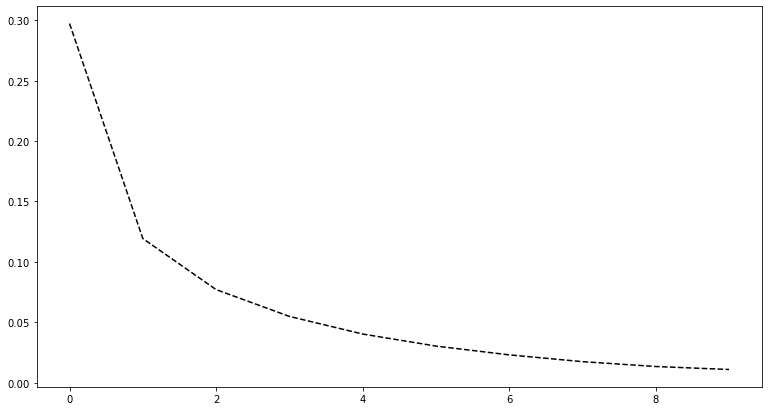

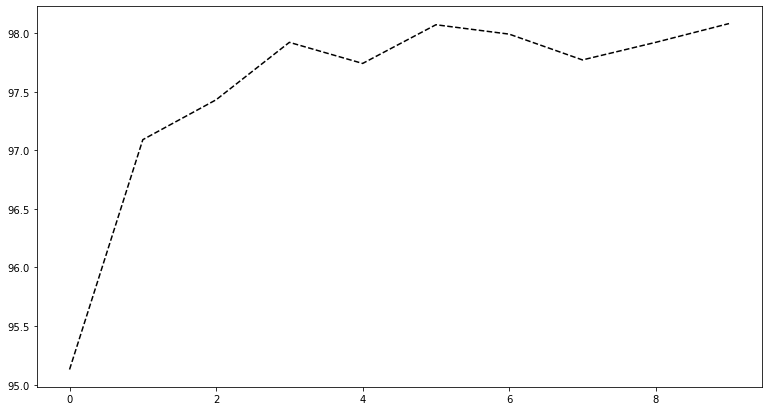

In [7]:
#绘制loss的变化
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(13,7))
axes.plot(LossList,'k--')

# 绘制Accurucy的变化
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13,7))
axes.plot(AccuryList, 'k--')


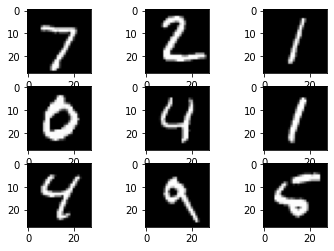

上面三张图片的真实结果： [7 2 1 0 4 1 4 9 5]
上面三张图片的预测结果： [7 2 1 0 4 1 4 9 5]


In [8]:
#测试样例
examples=iter(test_loader)
example_data,example_targets=examples.next()

#打印实际图片
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(example_data[i][0],cmap='gray')
plt.show()

#预测结果
images=example_data.reshape(-1,28*28).to(device)
labels=example_targets.to(device)
outputs=model(images).to('cpu')
print("上面三张图片的真实结果：", example_targets[0:9].detach().numpy())
print("上面三张图片的预测结果：", np.argmax(outputs[0:9].detach().numpy(), axis=1))